<a href="https://colab.research.google.com/github/Ssurf777/PointNet/blob/main/Pointnet_T_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

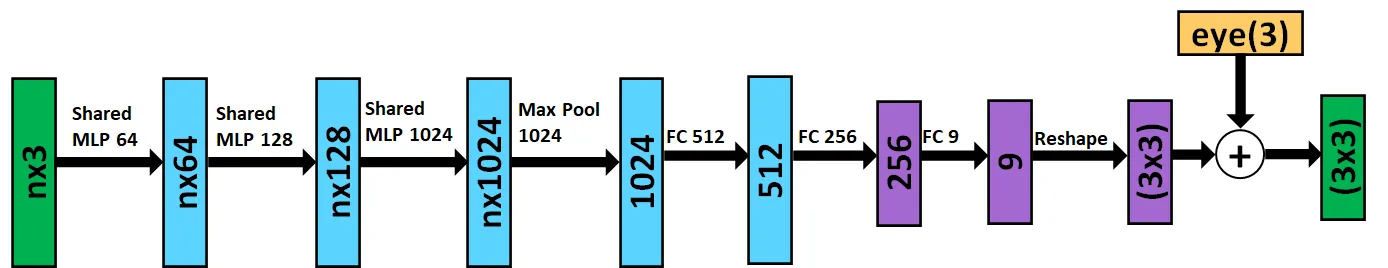

In [2]:

class Tnet(nn.Module):
  ''' T-Net Learns a Transformation matrix with a specified dimension '''
  def __init__(self,dim, num_points=2500):
    super(Tnet, self).__init__()

    # dimensions for transform matrix
    self.dim = dim

    self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
    self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
    self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

    self.linear1 = nn.Linear(1024,512)
    self.linear2 = nn.Linear(512,256)
    self.linear3 = nn.Linear(256,dim**2)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)
    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)


    self.max_pool = nn.MaxPool1d(kernel_size=num_points)
  def forward(self,x):
    bs = x.shape[0]

    # pass throught shared MLP layers (conv1d)
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))

    # max pool over num points
    x = self.max_pool(x).view(bs,-1)

    # pass through MLP
    x = self.bn4(F.relu(self.linear1(x)))
    x = self.bn5(F.relu(self.linear2(x)))
    x = self.linear3(x)

    # initialize identity matrix
    iden = torch.eye(self.dim, requires_grad=True).repeat(bs,1,1)
    if x.is_cuda:
      iden = iden.cuda()

    x = x.view(-1, self.dim, self.dim) + iden
    return x

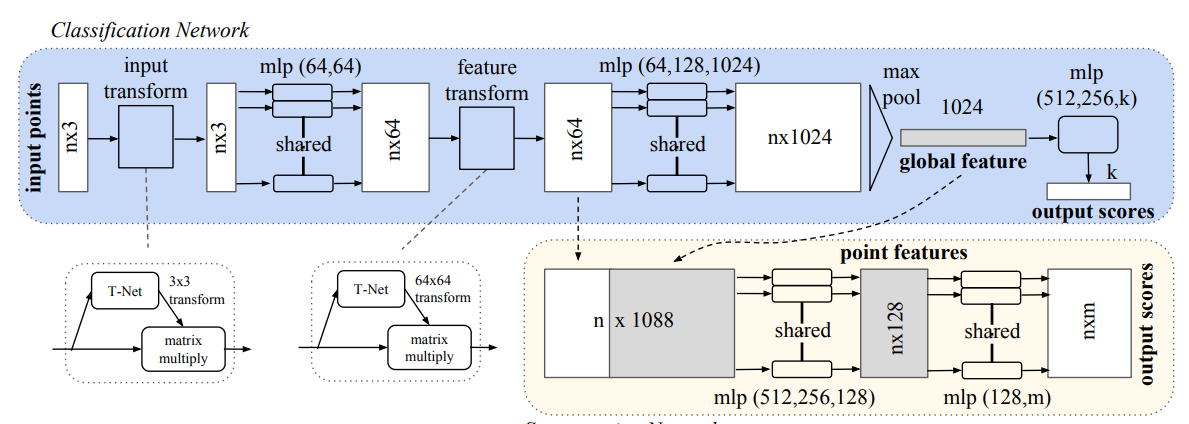

In [3]:
# Point Net Backbone
class PointNetBackbone(nn.Module):
  def __init__(self, num_points=2500, num_global_feats=1024, local_feat=True):
      super(PointNetBackbone, self).__init__()

      # if true concat local and global features
      self.num_points = num_points
      self.num_global_feats = num_global_feats
      self.local_feat = local_feat

      # Spatial Transformer Networks (T-nets)
      self.tnet1 = Tnet(dim=3, num_points=num_points)
      self.tnet2 = Tnet(dim=64, num_points=num_points)

      # shared MLP1
      self.conv1 = nn.Conv1d(3, 64, kernel_size = 1)
      self.conv2 = nn.Conv1d(64, 64, kernel_size = 1)

      # shared MLP2
      self.conv3 = nn.Conv1d(64, 64, kernel_size = 1)
      self.conv4 = nn.Conv1d(64, 128, kernel_size = 1)
      self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size = 1)

      # batch norms for bothe shared MLPs
      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(64)
      self.bn3 = nn.BatchNorm1d(64)
      self.bn4 = nn.BatchNorm1d(128)
      self.bn5 = nn.BatchNorm1d(self.num_global_feats)

      # max pool to get the global features
      self.max_pool = nn.MaxPool1d(kernel_size= num_points, return_indices=True)

  def forward(self, x):

    # get batch size
    bs = x.shape[0]

    # pass through first Tnet to get transform matrix
    A_input = self.tnet1(x)

    # perform first transformation across each point in the batch
    x = torch.bmm(x.transpose(2,1), A_input).transpose(2, 1)

    # pass through first shared MLP
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))

    # get feature transform
    A_feat =self.tnet2(x)

    # perform second transformation across each (64 dim) feature in the batch
    x = torch.bmm(x.transpose(2,1), A_feat).transpose(2,1)

    # store local point features for segmentation head
    local_features = x.clone()

    # pass throught second MLP
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.bn5(F.relu(self.conv5(x)))

    # get global feature vector and critical indexes
    global_features, critical_indexes = self.max_pool(x)
    global_features = global_features.view(bs, -1)
    critical_indexes = critical_indexes.view(bs, -1)
    if self.local_feat:
      features = torch.cat( (local_features,
                             global_features.unsqueeze(-1).repeat(1, 1, self.num_points)),
                             dim=1)
      return features, critical_indexes, A_feat
    else:
      return global_features, critical_indexes, A_feat


In [4]:
# classification Heat
class PointNetClassHead(nn.Module):
  def __init__(self, num_points=2500, num_global_feats = 1024, k=2):
    super(PointNetClassHead, self).__init__()
    # get the backbone ( only need global features for classification)
    self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=False)

    # MLP for classification
    self.linear1 = nn.Linear(num_global_feats, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, k)

    # batch norm for the first 2 linear layers
    self.bn1 = nn.BatchNorm1d(512)
    self.bn2 = nn.BatchNorm1d(256)

    # the paper states that batch norm was only added to the layer
    # before the classication layer , but another version adds dropout to the first 2 layers
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x, crit_idxs, A_feat = self.backbone(x)
    x = self.bn1(F.relu(self.linear1(x)))
    x = self.bn2(F.relu(self.linear2(x)))
    x = self.dropout(x)
    x = self.linear3(x)

    return x, crit_idxs, A_feat

In [11]:
# Segmentation Head
class PointNetSegHead(nn.Module):
  '''segmentation Head'''
  def __init__(self, num_points=2500, num_global_feats = 1024, m=2):
    super(PointNetSegHead, self).__init__()
    self.num_points = num_points
    self.m = m

    # get the backbone
    self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

    # shared MLP
    num_features = num_global_feats + 64 # local and global features
    self.conv1 = nn.Conv1d(num_features, 512 , kernel_size=1)
    self.conv2 = nn.Conv1d(512, 256 , kernel_size=1)
    self.conv3 = nn.Conv1d(256, 128 , kernel_size=1)
    self.conv4 = nn.Conv1d(128, m , kernel_size=1)

    # batch norm for the first 2 linear layers
    self.bn1 = nn.BatchNorm1d(512)
    self.bn2 = nn.BatchNorm1d(256)
    self.bn3 = nn.BatchNorm1d(128)


  def forward(self, x):
    x, crit_idxs, A_feat = self.backbone(x)

    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.conv4(x)

    x = x.transpose(2,1)

    return x, crit_idxs, A_feat

In [12]:
# test
def main():
  test_data = torch.rand(32, 3, 2500)

  ## test T-net
  tnet = Tnet(dim = 3)
  transform = tnet(test_data)
  print(f'T-net output shape:{transform.shape}')

  ## test backbone
  pointfeat = PointNetBackbone(local_feat=False)
  out, _, _ = pointfeat(test_data)
  print(f'Global Features shape:{out.shape}')

  pointfeat = PointNetBackbone(local_feat=True)
  out, _, _ = pointfeat(test_data)
  print(f'Combined Features shape:{out.shape}')

  ## test on single batch
  pointfeat = PointNetBackbone(local_feat=True).eval()
  out, _, _ = pointfeat(test_data[0, : , :].unsqueeze(0))

  ## test classification head
  classifier = PointNetClassHead(k=5)
  out, _, _ = classifier(test_data)
  print(f'Class output shape:{out.shape}')

  classifier = PointNetClassHead(k=5).eval()
  out, _, _ = classifier(test_data[0, : ,:].unsqueeze(0))

  ## test segmenttation head
  seg = PointNetSegHead(m=3)
  out, _, _ = seg(test_data)
  print(f'Seg shape:{out.shape}')


if __name__ == '__main__':
  main()


T-net output shape:torch.Size([32, 3, 3])
Global Features shape:torch.Size([32, 1024])
Combined Features shape:torch.Size([32, 1088, 2500])
Class output shape:torch.Size([32, 5])
Seg shape:torch.Size([32, 2500, 3])
